# Модель подавления поверхностных волн

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Критика](#Критика)

## Постановка задачи

Подавить шумы, связанные с поверхностными волнами, на полевых сейсмограммах.

## Датасет

Исходная сейсмограмма (176К трасс) и сейсмограмма после первой итерации подавления шума.

Загрузка данных:

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segyio

sys.path.append('..')

from batchflow import Dataset, DatasetIndex, Pipeline, B, V, best_practice
from batchflow.models.tf import UNet

from geolog import SeismicBatch, SegyFilesIndex, FieldIndex, TraceIndex

%env CUDA_VISIBLE_DEVICES=1

path_raw = '/home/egor/Desktop/Noise/D01_Raw_shots.sgy'
path_lift = '/home/egor/Desktop/Noise/D02_LIFT_1.sgy'

index = (SegyFilesIndex(name='raw', path=path_raw)
         .merge(SegyFilesIndex(name='lift', path=path_lift)))

env: CUDA_VISIBLE_DEVICES=1


Создание обучающией и тестовой частм датасета

In [2]:
field_index = FieldIndex(index)
ffid = field_index.indices
ffid

Int64Index([111906, 111907, 111908, 111909, 111910, 111911, 111912, 111913,
            111914, 111915, 111916, 111917, 111918, 111919, 111920, 111921,
            111922, 111923, 111924, 111925, 111927, 111928, 111929, 111930,
            111931, 111932, 111933, 111934, 111935, 111936, 111937, 111938,
            111939, 111940, 111941, 111942, 111943, 111944, 111945, 111946,
            111948, 111950, 111951, 111952, 111953, 111954, 111955, 111956,
            111957, 111958, 111959],
           dtype='int64', name='field_id')

In [6]:
train_set = Dataset(field_index.create_subset(ffid[:5]), SeismicBatch)
test_set = Dataset(field_index.create_subset(ffid[5:]), SeismicBatch)

Пример исходной сейсмограммы

In [7]:
batch = (train_set.next_batch(len(train_set))
         .load(components=('raw', 'lift'), sort_by='seq_number')
         .to_2d(components=('raw', 'lift'))
        )

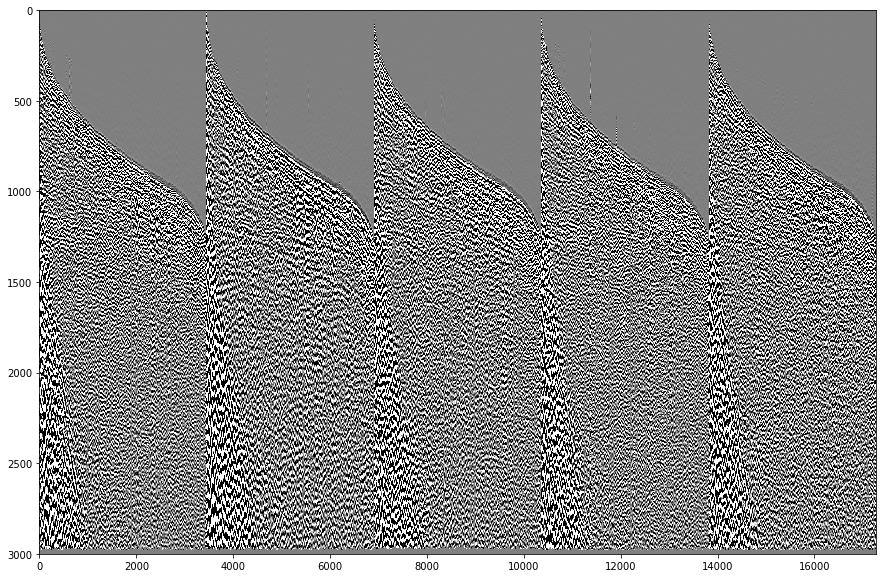

In [8]:
cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow(np.vstack(batch.raw).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

Рузультат ручной обработки поверхностных волн

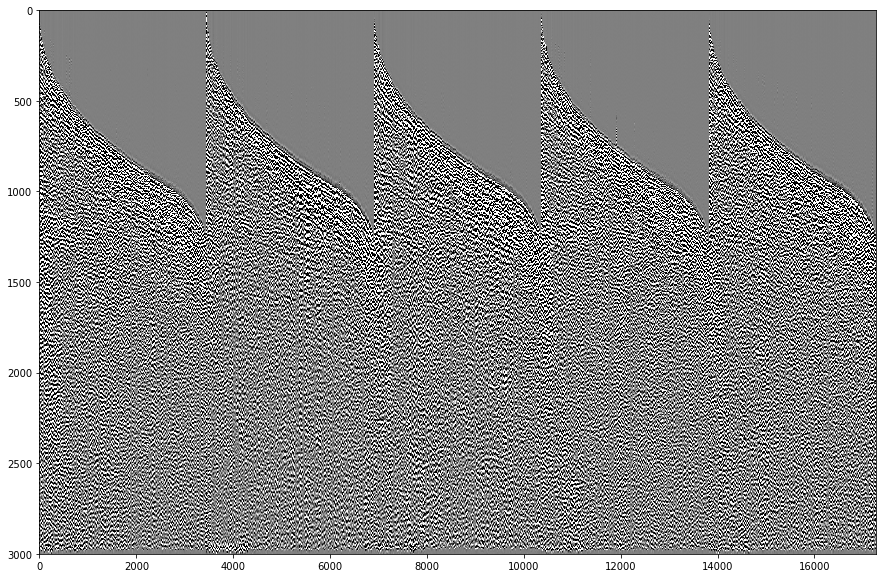

In [9]:
cv = 0.1
plt.figure(figsize=(15, 10))
plt.imshow(np.vstack(batch.lift).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Архитектура

Используется модель типа U-net глубиной 4. Задание конфигурации модели:

In [10]:
import tensorflow as tf
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3001, 1)}, 
                   y={'name':'targets', 'shape': (3001, 1)}),
    'body/filters': [8, 16, 32, 64, 128],
    'body/encoder': dict(layout='caca', kernel_size=3, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=3, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=3, strides=2, dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

## Обучение

Пайплайн обучения модели

In [11]:
train_set = Dataset(TraceIndex(field_index.create_subset(ffid[:5])), SeismicBatch)

In [12]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(list(batch.raw), -1),
                          'y': np.expand_dims(list(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), sort_by='seq_number')
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='a')
                 )

Запуск обучения

In [13]:
batch_size = 30

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=1, drop_last=True, shuffle=True, bar=True)

100%|█████████▉| 575/576 [05:19<00:00,  1.69it/s]


График функции потерь в зависимости от числа итераций

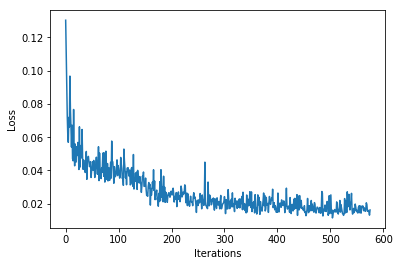

In [14]:
loss = train_pipeline.get_variable("loss")
plt.plot(loss)
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

## Инференс

Пайплайн инференса

In [19]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(list(batch.raw), -1)}}

predict_pipeline = (Pipeline()
                    .load(components='raw', sort_by='seq_number')
                    .import_model('unet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list())
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('predictions'), mode="a"))

Запуск процедуры инференса

In [32]:
test_set = Dataset(TraceIndex(field_index.create_subset(ffid[5:10])), SeismicBatch)

In [25]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=False)

Сборка трасс

In [26]:
predicts = np.vstack(predict_pipeline.get_variable("predictions"))

Результат подавлениия поверхностных волн

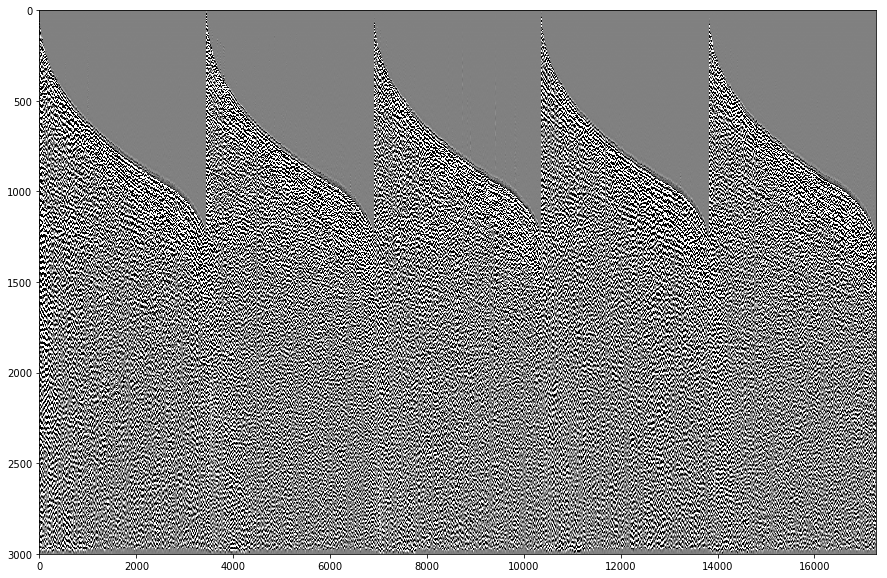

In [27]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow(np.squeeze(predicts).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Оценка модели

Разница между ручной обработкой и предсказанием модели

In [36]:
test_set = Dataset(field_index.create_subset(ffid[5:10]), SeismicBatch)

batch = (test_set.next_batch(len(test_set))
         .load(components='lift', sort_by='seq_number')
         .to_2d(components='lift')
        )

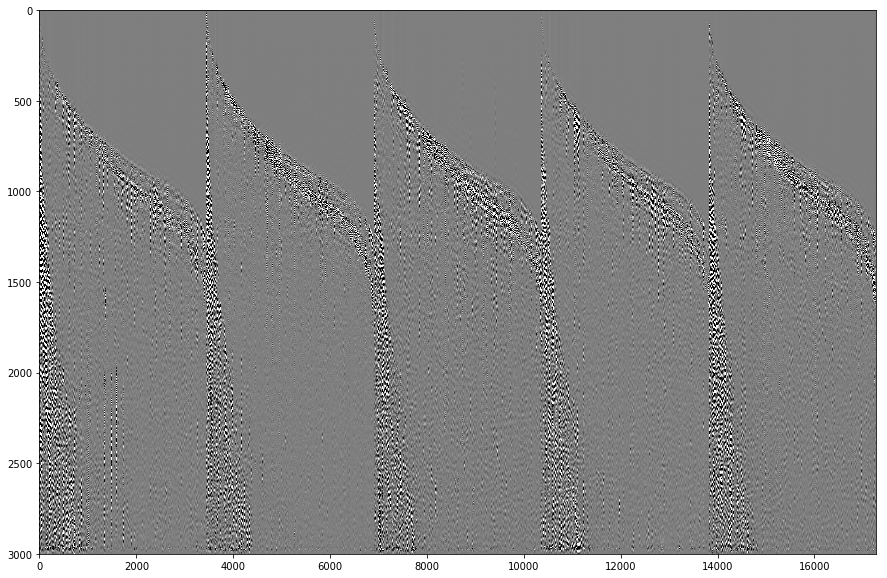

In [37]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow(np.vstack(batch.lift).T - np.squeeze(predicts).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Критика

На картинке разницы ручной обработки и предсказания модели заметны остаточные поверхностные волны. Их можно пробовать устранять, увеличивая глубину и число фильтров в сети. 